In [29]:
%load_ext autoreload
%autoreload 2
from storytelling import *
from bert_extractive_summarizer.summarizer import Summarizer
from bert_extractive_summarizer.summarizer.coreference_handler import CoreferenceHandler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
word_embeddings = LoadWordEmbeddings(fil="../dat/glove/glove.twitter.27B.100d.txt")

In [131]:
datfile = "../dat/wildfire_yosemite.csv"
#datfile = "../dat/1966.csv.gz"
df = pd.read_csv(datfile, index_col="id")
df = df[df["rt_id"].isna()]
print(df.shape)

(3582, 11)


In [132]:
df1 = df[df["user_followers_count"]>10**3]
df1.shape

(1848, 11)

In [133]:
tids, row_sentences, clean_sentences = readsencence(df1)

In [134]:
print(len(tids), tids[:3])

1363 [370587609350684672, 370595563042906112, 370587253325578240]


In [135]:
sentence_vectors = Sentence2WE(clean_sentences, word_embeddings)

In [136]:
sentence_vectors
print(sentence_vectors.shape)

(1363, 100)


(1363, 40)


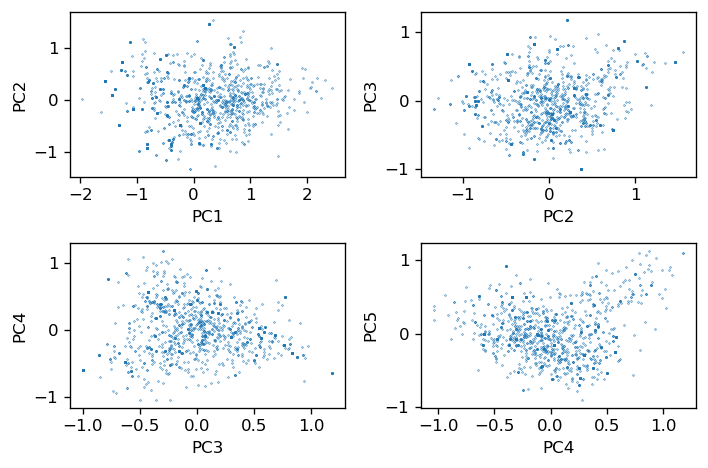

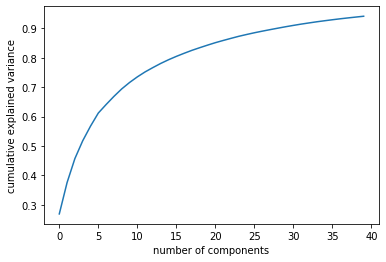

In [137]:
pca = PCA(n_components=40, svd_solver='arpack')
X = pca.fit_transform(sentence_vectors)
print(X.shape)
fig, axs = plt.subplots(2,2,dpi=120)
for i,(j,k) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axs[j,k].scatter(X[:,i], X[:,i+1], s=0.1)
    axs[j,k].set_xlabel("PC%d"%(i+1))
    axs[j,k].set_ylabel("PC%d"%(i+2))
fig.tight_layout()
plt.show()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [157]:
for nc, vexp in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if vexp > 0.9:
        NC = nc+1
        break
print(NC)

29


In [160]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(X[:, :NC])

In [164]:
#Agg = sklearn.cluster.AgglomerativeClustering(n_clusters=10, affinity="cosine",linkage="average")
Agg = sklearn.cluster.AgglomerativeClustering(distance_threshold=1.5, n_clusters=None, affinity="cosine",linkage="complete")
Agg = Agg.fit(X[:, :NC])
clusters = Agg.fit_predict(X[:, :NC])
groups = AssignCluster(Y, clusters)
print(len(groups))
#centers = kmeans.cluster_centers_ 

9


In [165]:
Agg.labels_

array([0, 0, 0, ..., 7, 7, 2])

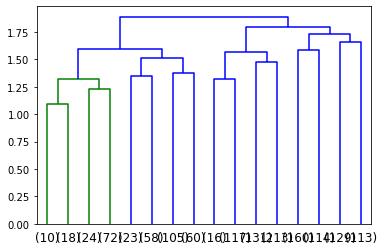

In [166]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plot_dendrogram(Agg, truncate_mode='level', p=3)

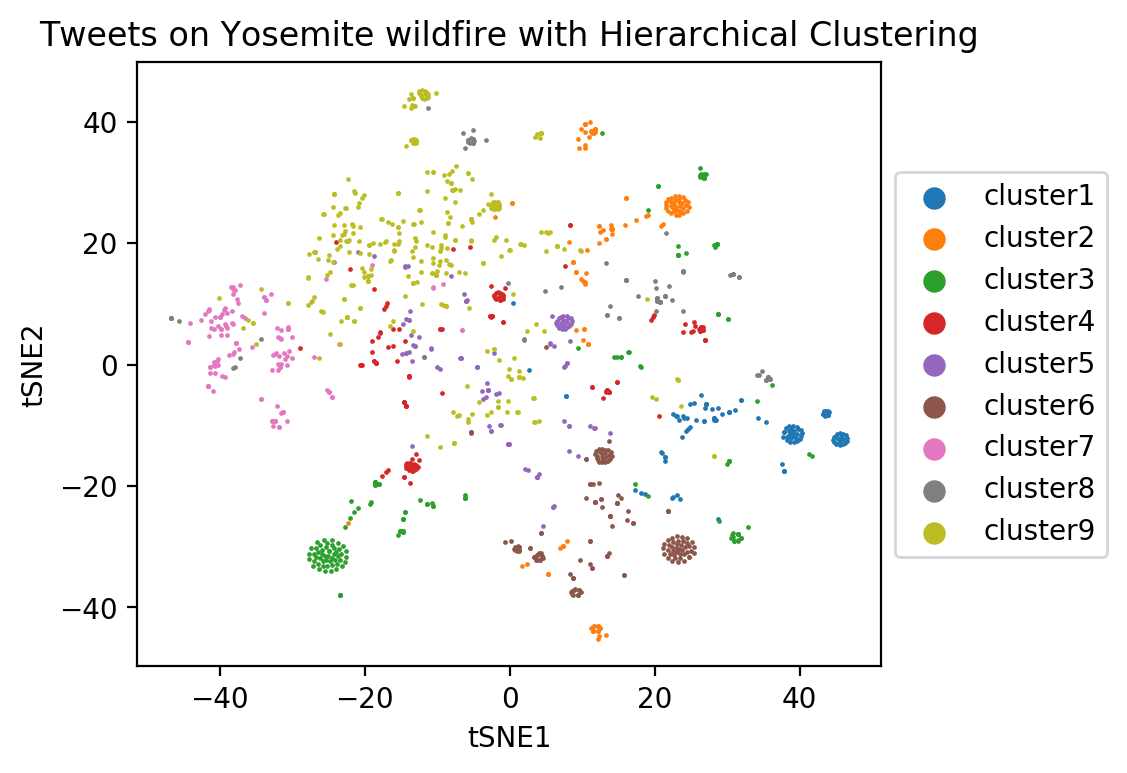

In [167]:
fig = plt.figure(dpi=200)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
#ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.title("Tweets on Yosemite wildfire with Hierarchical Clustering")
plt.show()

In [168]:
Totoal_art = []
for i in range(max(clusters)+1):
    topics = np.where(clusters==i)[0]
    if len(topics) < 5:
        continue
    topic_tweet_idxs = np.array([tids[int(i)] for i in topics])
    topic_sentence_vectors = np.array([sentence_vectors[int(i)] for i in topics])
    sim_mat = TextRankScoreMat(topic_sentence_vectors)
    threashold = 0.8
    rm_idx = []
    kept_idx = []
    for i in range(sim_mat.shape[0]):
        if i in rm_idx:
            continue
        kept_idx.append(i)
        for j in range(sim_mat.shape[1]):
            if sim_mat[i,j]>threashold:
                rm_idx.append(j)   
    #print(len(kept_idx))
    art = []
    selected_Clean = []
    for i in kept_idx:
        dat_id = topics[i]
        tid = tids[dat_id]
        date = datetime.strptime(df1.loc[tid, "created_at"],'%a %b %d %X %z %Y').strftime("%m-%d-%X")
        if len(row_sentences[dat_id]) > 20:
            art.append(row_sentences[dat_id])
            selected_Clean.append(clean_sentences[dat_id])
    #print(art)
    Totoal_art.append(".".join(art))
#print(Totoal_art)
print("\n".join(Totoal_art))

Yosemite area wildfire balloons in size overnight.NOW AT 11: Wildfire near Yosemite has more than tripled in sizew/ 2,500 buildings threatened by flames. WATCH LIVE:."Yosemite-Area Wildfire Balloons in Size Overnight":.Yosemite-area wildfire balloons to 84 square miles.Not Yosemite!  Oh no. wildfire.theblaze  tcot Yosemite-area wildfire balloons to 84 square miles (twincities).RimFire  issues emergency proclamation Thurs. for the wildfire near Yosemite in Tuolumne County.RimFireCA Fire Fighters Lose Ground Against Growing WildfireCamp Closeing info.Wildfire near Yosemite surgesprompts evacuations (from ).WTH! does wildfire in yosemite have 2 do with big $$$ green ngo asking for $$$ 2nite?.Yosemite-area wildfire triples in size in one day.The latest on the wildfire threatening Yosemiteahead on . PHOTO (via AP):.Yikes.  : AP writer leans back in his chair after writing opening paragraphsays to himself"Nailed it.".Many fleeing Yosemite-area wildfirewhich has grown to 99 square miles.": Ri

In [169]:
out = open("test.psodu.txt", 'wt')
out.write("\n".join(Totoal_art))

4049

In [170]:
model = "bert-large-uncased"
hidden = -2
reduce_option = "mean"
model = Summarizer(
    model = model,
    hidden = hidden,
    reduce_option = reduce_option)

In [171]:
result = model("\n".join(Totoal_art))#, min_length=80)
print(result)

Yosemite area wildfire balloons in size overnight. Wildfire has doubled in sizespread to Yosemite..Photos from the massive Yosemite rimfire wildfire:.": TouristsResidents Evacuate as Yosemite Wildfire Grows Exponentially. Yosemite-area wildfire triples in size overnight. Beastly fire disrupts Idaho vacation heavensmoke casts shadow over economy. Smokey the Bear is not impressed wildfire sunrise tahoe yosemite rimfire americanfire sadface.42.000 preciosas hectáreas quemadas Ragingfast-moving California wildfire threatens Yosemite National Park. More evacuations urged as Calif. Wildfire grows to 165 square miles. Yosemite wildfire impacting SF waterpower operations SFO YosemiteFire rimfire


In [172]:
result = model("\n".join(Totoal_art), min_length=80)
print(result)

NOW AT 11: Wildfire near Yosemite has more than tripled in sizew/ 2,500 buildings threatened by flames. does wildfire in yosemite have 2 do with big $$$ green ngo asking for $$$ 2nite?.Yosemite-area wildfire triples in size in one day. Governor Brown has declared a "state of emergency" over the out-of-control wildfire. Beastly fire disrupts Idaho vacation heavensmoke casts shadow over economy -.[VOA] Wildfire Rages to Yosemite's Edge in HotDry Weather
: Wildfire near Yosemite National Park threatens 2,500 homeshotels and camp buildings.
